In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import pickle

In [50]:
from pytorch_lightning.utilities.model_summary import summarize
from datasets import load_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from estimator import TransformerEstimator

In [8]:
dataset = load_dataset("electricity_load_diagrams", "lstnet")

Generating train split:   0%|          | 0/320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2240 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/320 [00:00<?, ? examples/s]

Dataset electricity_load_diagrams downloaded and prepared to /home/kashif/.cache/huggingface/datasets/electricity_load_diagrams/lstnet/1.0.0/fe3dd01c39428ad92523a7ced0df3fdf669cb0548b3dd16fb9f7009381aa440f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
freq = "1H"
prediction_length = 24

In [11]:
train_ds = ListDataset(dataset["train"], freq=freq)

In [12]:
val_ds = ListDataset(dataset["validation"], freq=freq)

In [13]:
test_ds = ListDataset(dataset["test"], freq=freq)

## Sclaing Experiments

We keep the individual layers of the Transformer unchanged: i.e. 
* the model dimension
* the width of the feed-forward layer `dim_feedforward=16`; 
* and the number of attention heads `nhead=2`

We examine the change in the test set metrics as the number of parameters increases with the following three depth scaling approaches:
* Encoder Scaling: vary the `num_encoder_layers` while `num_decoder_layers` is kept fixed
* Decoder Scaling: vary the `num_decoder_layers` while the `num_encoder_layers` is kept fixed
* Symmetric Scaling: vary both the `num_encoder_layers` and `num_decoder_layers` but being equal

In [51]:
layers = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 48, 56, 64]

### Encoder Scaling

In [52]:
enc_metrics = []
for layer in layers:
    estimator = TransformerEstimator(
        freq=freq,
        prediction_length=prediction_length,
        context_length=prediction_length*7,

        nhead=2,
        num_encoder_layers=layer,
        num_decoder_layers=6,
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[320],
        embedding_dimension=[5],

        batch_size=128,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='auto', gpus=1),
    )
    
    predictor = estimator.train(
        training_data=train_ds,
        validation_data=val_ds,
        num_workers=8,
        shuffle_buffer_length=1024
    )
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds, 
        predictor=predictor
    )
    forecasts = list(forecast_it)
    if layer == layers[0]:
        tss = list(ts_it)
    
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
    agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
    enc_metrics.append(agg_metrics.copy())

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  as

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5f86dc0d0>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1388, in __del__
    self._shutdown_workers()
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1371, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5f86dc0d0>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/l

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a 

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a 

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError: 
can only test a child process  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd5f86dc0d0>

Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1388, in __del__
    self._shutdown_workers()
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1371, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProc

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  as

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a 

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  as

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

HPU available: False, using: 0 HPUs
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is 

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  as

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluont

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  as

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluont

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:424: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  assert self._freq_base is None or self._freq_base == start.freq.base, (
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:365: FutureWarning: Timestamp.freq is deprecated and will be removed in a 

Sanity Checking: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Ti

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/spl

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Times

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/fea

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

Validation: 0it [00:00, ?it/s]

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:370: Fu

/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.start_date.freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:313: FutureWarning: Timestamp.freq is deprecated and will be removed in a f

In [53]:
enc_metrics_out = open("elec_enc_metrics.pkl", "wb")

In [56]:
pickle.dump(enc_metrics, enc_metrics_out)

In [57]:
enc_metrics_out.close()

Text(0.5, 1.0, 'Encoder Scaling')

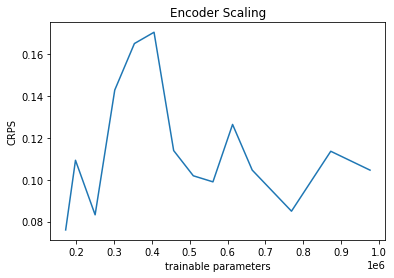

In [66]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["mean_wQuantileLoss"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("CRPS")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

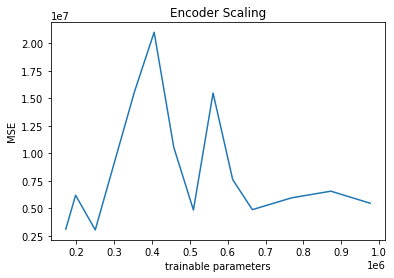

In [68]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["MSE"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MSE")
plt.title("Encoder Scaling")

Text(0.5, 1.0, 'Encoder Scaling')

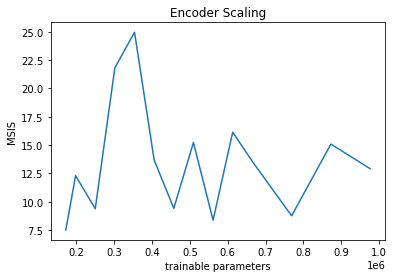

In [72]:
plt.plot(
    [metrics["trainable_parameters"] for metrics in enc_metrics],
    [metrics["MSIS"] for metrics in enc_metrics],   
)
plt.xlabel("trainable parameters")
plt.ylabel("MSIS")
plt.title("Encoder Scaling")

### Decoder Scaling

### Symmetric Scaling